# Visual Attention per Area Of Interest

In [1]:
import pandas as pd
import regex as re
import matplotlib.pyplot as plt
import seaborn as sns
import json
import modules.GenSnippetsLib as snippets
from modules import stats as util_stats
from pygments.lexers import PythonLexer
from tqdm.notebook import tqdm
import PIL
import PIL.Image
import numpy as np
from skimage.draw import ellipse
plt.rcParams['savefig.facecolor']='white'

## Load The Data

In [2]:
def click_data_to_list(click_data_string):
    click_data_list = []
    for click in click_data_string.split(" "):
        click = click.split("-")
        # extract the x and y coordinates from a string via regex
        x = int(re.search(r'\d+', click[0])[0])
        y = int(re.search(r'\d+', click[1])[0])
        click_data_list.append((x, y))
    return click_data_list#

def time_data_to_list(time_data_string):
    time_data_list = []
    for time in time_data_string.split(" "):
        time_data_list.append(float(time) / 1000)
    return time_data_list

In [3]:
df = pd.read_csv('./data/preprocessed_experiment_data.csv')
df = df[df["Outlier"] == False]
df = df.drop(columns=["Outlier"])

df["ClickData"] = df["ClickData"].apply(lambda x: click_data_to_list(x))
df["TimeData"] = df["TimeData"].apply(lambda x: time_data_to_list(x))
df["NumberOfClicks"] = df["ClickData"].apply(lambda x: len(x))
df["AverageTimeOfClicks"] = (df["ResponseTime"] / 1000) / df["NumberOfClicks"]

## Create the Bounding Boxes of the Areas of Interest

In [4]:
# prepare color mapping for aois
algorithms = df[["Algorithm"]].sort_values(by="Algorithm")["Algorithm"].unique()
programming_styles = df[["ProgrammingStyle"]].sort_values(by="ProgrammingStyle")["ProgrammingStyle"].unique()
algorithms = [x for x in algorithms]
programming_styles = [x.replace("-", "_") for x in programming_styles]

color_palette = sns.color_palette("hls", 16)
color_palette_mapping = {
    "Method" : color_palette[0],
    "MethodDeclaration" : color_palette[1],
    "MethodBody" : color_palette[2],
    "Helper" : color_palette[3],
    "HelperDeclaration" : color_palette[4],
    "HelperBody" : color_palette[5],
    "Iteration" : color_palette[6],
    "IterationHead" : color_palette[7],
    "IterationBody" : color_palette[8],
    "RecursiveCall" : color_palette[9],
    "RecursiveBaseCase" : color_palette[10],
    "HigherOrder" : color_palette[11],
    "ListComprehension" : color_palette[12],
    "InputPreparation" : color_palette[13],
    "StartOfAlgorithm" : color_palette[14],
    "Class" : color_palette[15],
}
aoi_colors = color_palette
aoi_numbers = {name : idx for idx, (name, _value) in enumerate(color_palette_mapping.items())}
aoi_names = [name for name, _value in color_palette_mapping.items()]

def aoi_idx_to_convoluted_idx(aoi_idx):
    if aoi_idx < 5:
        return aoi_idx
    if 6 <= aoi_idx <= 12:
        return 6
    if 13 <= aoi_idx:
        return aoi_idx-6

def aoi_name_to_convoluted_name(aoi_name):
    if aoi_name in ["Iteration", "IterationHead", "IterationBody",
                    "Recursion", "RecursiveCall", "RecursiveBaseCase",
                    "HigherOrder",
                    "ListComprehension"]:
        return "StyleSpecific"
    return aoi_name

color_palette = sns.color_palette("hls", 10)
color_palette_mapping_convoluted = {
    "Method" : color_palette[0],
    "MethodDeclaration" : color_palette[1],
    "MethodBody" : color_palette[2],
    "Helper" : color_palette[3],
    "HelperDeclaration" : color_palette[4],
    "HelperBody" : color_palette[5],
    "StyleSpecific" : color_palette[6],
    "InputPreparation" : color_palette[7],
    "StartOfAlgorithm" : color_palette[8],
    "Class" : color_palette[9],
}
aoi_colors_convoluted = color_palette
aoi_numbers_convoluted = {name : idx for idx, (name, _value) in enumerate(color_palette_mapping_convoluted.items())}
aoi_names_convoluted = [name for name, _value in color_palette_mapping_convoluted.items()]

In [5]:
# create bounding boxes and visualize them
def from_canvas(fig):
    lst = list(fig.canvas.get_width_height())
    lst.append(3)
    return PIL.Image.fromarray(np.frombuffer(fig.canvas.tostring_rgb(),dtype=np.uint8).reshape(lst))

df_bounding_box = pd.DataFrame(columns=["Algorithm", "ProgrammingStyle", "BoundingBoxes", "ImageDimension"])
font_path="\\data\\fonts\\ttf\\"
offset = 3


for algorithm in tqdm(algorithms):
    for programming_style in programming_styles:
        # load the image and generate bb code info
        file_name = './data/CodeSnippets/Generators/' + algorithm + '_' + programming_style + '.json'
        try:
            image, result = snippets.create_image(file_name, font_path=font_path, lexer=PythonLexer)
            y, x = image.size[::-1]
            dimension = (x, y)
        except Exception as e:
            print(file_name + ":" + str(e))
            continue
        # extract the areas of interest in the image
        areas_of_interest = set()
        for letter in result:
            for aoi in letter["AOI"]:
                areas_of_interest.add(aoi)

        # create the bounding boxes
        disjoint_areas_of_interest = []
        for aoi in areas_of_interest:
            upper_left_x = 0
            upper_left_y = 0
            lower_right_x = 0
            lower_right_y = 0
            has_aoi = False
            for letter in result:
                if letter["BoundingBox"][0] == 0 and letter["BoundingBox"][1] == 0 and letter["BoundingBox"][2] == 0 and letter["BoundingBox"][3] == 0:
                    continue

                if aoi in letter["AOI"]:
                    if not has_aoi:
                        upper_left_x = letter["BoundingBox"][0] - offset
                        upper_left_y = letter["BoundingBox"][1] - offset
                        lower_right_x = letter["BoundingBox"][2] + offset
                        lower_right_y = letter["BoundingBox"][3] + offset
                        has_aoi = True
                    else:
                        upper_left_x = min(upper_left_x, letter["BoundingBox"][0] - offset)
                        upper_left_y = min(upper_left_y, letter["BoundingBox"][1] - offset)
                        lower_right_x = max(lower_right_x, letter["BoundingBox"][2] + offset)
                        lower_right_y = max(lower_right_y, letter["BoundingBox"][3] + offset)
                else:
                    if has_aoi:
                        disjoint_areas_of_interest.append((aoi, [upper_left_x, upper_left_y, lower_right_x, lower_right_y]))
                    has_aoi = False
                    upper_left_x = 0
                    upper_left_y = 0
                    lower_right_x = 0
                    lower_right_y = 0

            if has_aoi:
                disjoint_areas_of_interest.append((aoi, [upper_left_x, upper_left_y, lower_right_x, lower_right_y]))

        # create the bounding boxes without None aoi
        disjoint_areas_of_interest = [area for area in disjoint_areas_of_interest if area[0] != "None"]
        df_bounding_box = df_bounding_box.append(pd.DataFrame([[algorithm, programming_style.replace("_", "-"), disjoint_areas_of_interest, dimension]], columns=df_bounding_box.columns))
df_bounding_box

  0%|          | 0/11 [00:00<?, ?it/s]

,Algorithm,ProgrammingStyle,BoundingBoxes,ImageDimension
0,LinkedList,higher-order,"[(MethodDeclaration, [2, 655, 200, 675]), (Inp...","(594, 1206)"
0,LinkedList,iterative,"[(MethodDeclaration, [2, 551, 200, 571]), (Inp...","(362, 1154)"
0,LinkedList,list-comprehension,"[(MethodDeclaration, [2, 655, 200, 675]), (Inp...","(706, 1232)"
0,LinkedList,recursive,"[(MethodDeclaration, [2, 239, 288, 260]), (Inp...","(506, 868)"
0,apply,higher-order,"[(MethodDeclaration, [2, 5, 256, 26]), (InputP...","(394, 166)"
0,apply,iterative,"[(MethodDeclaration, [2, 5, 256, 26]), (InputP...","(394, 244)"
0,apply,list-comprehension,"[(MethodDeclaration, [2, 5, 256, 26]), (InputP...","(394, 166)"
0,apply,recursive,"[(MethodDeclaration, [2, 5, 256, 26]), (InputP...","(562, 244)"
0,computer,higher-order,"[(MethodDeclaration, [2, 369, 240, 390]), (Inp...","(882, 738)"
0,computer,iterative,"[(MethodDeclaration, [2, 369, 240, 390]), (Inp...","(738, 842)"


## Map the Visual Attention Measures to the Areas of Interest

In [6]:
def get_ellipse_mask(center, x_radius, y_radius, dimension, std_value = 1.0):
    """
    Returns a mask of an ellipse with the given center, x-radius, and y-radius.
    """
    x_dim = max(center[0]+2*x_radius+1, dimension[0])
    y_dim = max(center[1]+2*y_radius+1, dimension[1])
    mask = np.zeros((y_dim, x_dim), dtype=np.float32)
    rr, cc = ellipse(center[1], center[0], y_radius, x_radius)
    mask[rr, cc] = std_value
    mask = mask[:dimension[1], :dimension[0]]
    return mask

def get_rectangular_mask(points, dimension, std_value = 1.0):
    """
    Returns a mask of a rectangular with the given points.
    """
    x_dim = max(points[2]+1, dimension[0])
    y_dim = max(points[3]+1, dimension[1])
    mask = np.zeros((y_dim, x_dim), dtype=np.float32)
    mask[points[1]:points[3]+1, points[0]:points[2]+1] = std_value
    mask = mask[:dimension[1], :dimension[0]]
    return mask

In [7]:
settings = json.load(open("./data/settings.json"))
x_radius = settings["radius_x"]+settings["grad_radius"]//2
y_radius = settings["radius_y"]+settings["grad_radius"]//2

df = pd.merge(df, df_bounding_box, on=["Algorithm", "ProgrammingStyle"])

In [8]:
df_aoi = pd.DataFrame([], columns=["Algorithm", "ProgrammingStyle", "Participant", "Number", "Duration", "AOI"])
iteration_categroies = ["Iteration", "IterationHead", "IterationBody"]
recursive_categroies = ["RecursiveCall", "RecursiveBaseCase"]
list_comprehension_categroies = ["ListComprehension"]
higher_order_categroies = ["HigherOrder"]

for idx, row in tqdm(df.iterrows(), total=df.shape[0]):
    algorithm = row["Algorithm"]
    programming_style = row["ProgrammingStyle"]
    dimension = row["ImageDimension"]
    clicks = row["ClickData"]
    participant = row["ID"]

    duration_per_click = row["TimeData"]
    duration_tmp = [duration_per_click[0]]
    for duration_idx, value in enumerate(duration_per_click):
        if duration_idx == 0:
            continue
        duration_tmp.append(value-duration_per_click[duration_idx-1])
    duration_per_click = duration_tmp

    bounding_boxes = row["BoundingBoxes"]
    mask_bounding_boxes = [get_rectangular_mask(bounding_box, dimension) for _, bounding_box in bounding_boxes]
    names_of_bounding_boxes = [aoi_name for aoi_name, _ in bounding_boxes]

    for idx, (click, duration) in enumerate(zip(clicks, duration_per_click)):
        # get elliptical mask
        click_mask = get_ellipse_mask(click, x_radius, y_radius, dimension)
        aois_visited = set()
        # check if the click is in the bounding box of an aoi
        for bounding_box_name, bounding_box_mask in zip(names_of_bounding_boxes, mask_bounding_boxes):
            if np.sum(click_mask*bounding_box_mask) > 0:
                aois_visited.add(bounding_box_name)
        aois_visited_tmp = set()
        for aoi_name in aois_visited:
            if aoi_name in iteration_categroies:
                aois_visited_tmp.add("Iteration")
            elif aoi_name in recursive_categroies:
                aois_visited_tmp.add("Recursion")
            elif aoi_name in list_comprehension_categroies:
                aois_visited_tmp.add("ListComprehension")
            elif aoi_name in higher_order_categroies:
                aois_visited_tmp.add("HigherOrder")
            else:
                aois_visited_tmp.add(aoi_name)
        aois_visited = aois_visited_tmp

        df_aoi.loc[len(df_aoi)] = [algorithm, programming_style, participant, idx, duration, aois_visited]

df_aoi.reset_index(drop=True)
df_aoi

  0%|          | 0/278 [00:00<?, ?it/s]

,Algorithm,ProgrammingStyle,Participant,Number,Duration,AOI
0,apply,iterative,212,0,10.105,"{StartOfAlgorithm, InputPreparation}"
1,apply,iterative,212,1,24.330,"{Iteration, MethodBody, Method}"
2,apply,iterative,212,2,0.570,"{Iteration, MethodBody, Method}"
3,apply,iterative,212,3,4.187,"{Iteration, MethodBody, Method}"
4,apply,iterative,212,4,7.954,"{MethodDeclaration, Method}"
...,...,...,...,...,...,...
6597,LinkedList,list-comprehension,315,20,3.786,{InputPreparation}
6598,LinkedList,list-comprehension,315,21,0.533,{InputPreparation}
6599,LinkedList,list-comprehension,315,22,0.468,{InputPreparation}
6600,LinkedList,list-comprehension,315,23,0.484,{InputPreparation}


## Metrics

In [9]:
aoi_order = ['Class',
             'Method','MethodDeclaration','MethodBody',
             'Helper','HelperDeclaration','HelperBody',
             'InputPreparation', 'StartOfAlgorithm',
             'StyleSpecific']

In [10]:
df_metrics = pd.DataFrame([], columns=["Algorithm", "ProgrammingStyle", "Participant", "AOI", "Duration", "Amount"])
for group, df_group in tqdm(df_aoi.groupby(["Algorithm", "ProgrammingStyle", "Participant"])):
    algorithm = group[0]
    programming_style = group[1]
    participant = group[2]

    aoi_duration = {aoi_name : 0.0 for aoi_name in aoi_names_convoluted}
    aoi_amount = {aoi_name : 0 for aoi_name in aoi_names_convoluted}
    for idx, row in df_group.iterrows():
        duration = row["Duration"]
        aois_visited = row["AOI"]
        for aoi_name in aois_visited:
            aoi_name = aoi_name_to_convoluted_name(aoi_name)
            try:
                aoi_duration[aoi_name] += duration
                aoi_amount[aoi_name] += 1
            except:
                print(algorithm, programming_style, participant, aoi_name)
                assert False

    for aoi_name in aoi_names_convoluted:
        df_metrics.loc[len(df_metrics)] = [algorithm, programming_style, participant, aoi_name, aoi_duration[aoi_name], aoi_amount[aoi_name]]
df_metrics["Amount"] = df_metrics["Amount"].astype(float)
df_metrics["Duration"] = df_metrics["Duration"].astype(float)
df_metrics

  0%|          | 0/278 [00:00<?, ?it/s]

,Algorithm,ProgrammingStyle,Participant,AOI,Duration,Amount
0,LinkedList,higher-order,204,Method,25.186,8.0
1,LinkedList,higher-order,204,MethodDeclaration,12.515,3.0
2,LinkedList,higher-order,204,MethodBody,21.321,7.0
3,LinkedList,higher-order,204,Helper,0.000,0.0
4,LinkedList,higher-order,204,HelperDeclaration,0.000,0.0
...,...,...,...,...,...,...
2775,store,recursive,320,HelperBody,29.130,19.0
2776,store,recursive,320,StyleSpecific,39.201,25.0
2777,store,recursive,320,InputPreparation,27.612,20.0
2778,store,recursive,320,StartOfAlgorithm,0.832,1.0


## Descriptive: Number Of Clicks per AOI

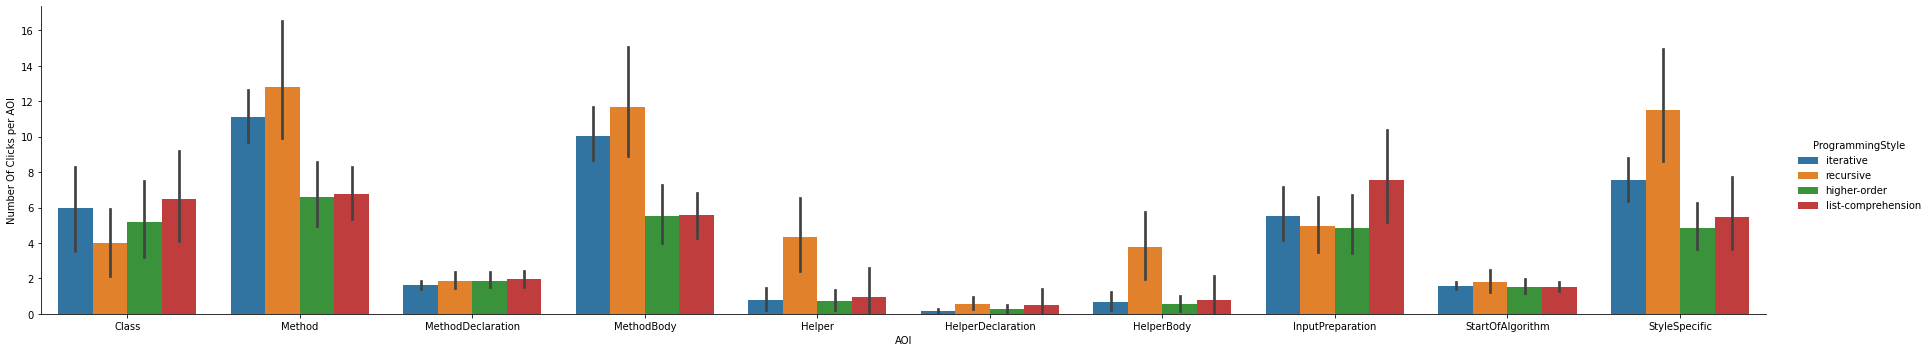

In [11]:
df_tmp = df_metrics.copy()

ax = sns.catplot(x="AOI", y="Amount", hue="ProgrammingStyle", data=df_tmp, kind="bar", height=5,
                 aspect=5, hue_order=["iterative", "recursive", "higher-order", "list-comprehension"],
                 order=aoi_order)
ax.tight_layout()
ax.set(ylabel='Number Of Clicks per AOI')
plt.savefig("./results/RQ2/figures/RQ2_NumberOfClicks_PerAOI.png")
plt.show()
plt.close('all')

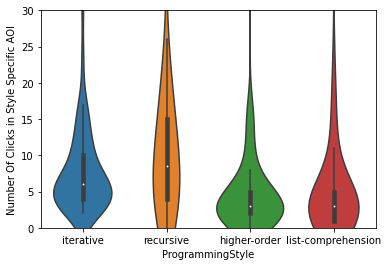

In [12]:
df_total = df_metrics.copy()
df_total["Amount"] = df_total["Amount"].astype(float)
df_total = df_total[df_total["AOI"] == "StyleSpecific"]
ax = sns.violinplot(x="ProgrammingStyle", y="Amount", data=df_total,
                    order=["iterative", "recursive", "higher-order", "list-comprehension"])
ax.set_ylabel('Number Of Clicks in Style Specific AOI')
ax.set(ylim=(0.0, 30.0))
plt.savefig("./results/RQ2/figures/RQ2_NumberOfClicks_PerStyleSpecific.png")
plt.show()
plt.close('all')

## Descriptive: Time Of Clicks per AOI

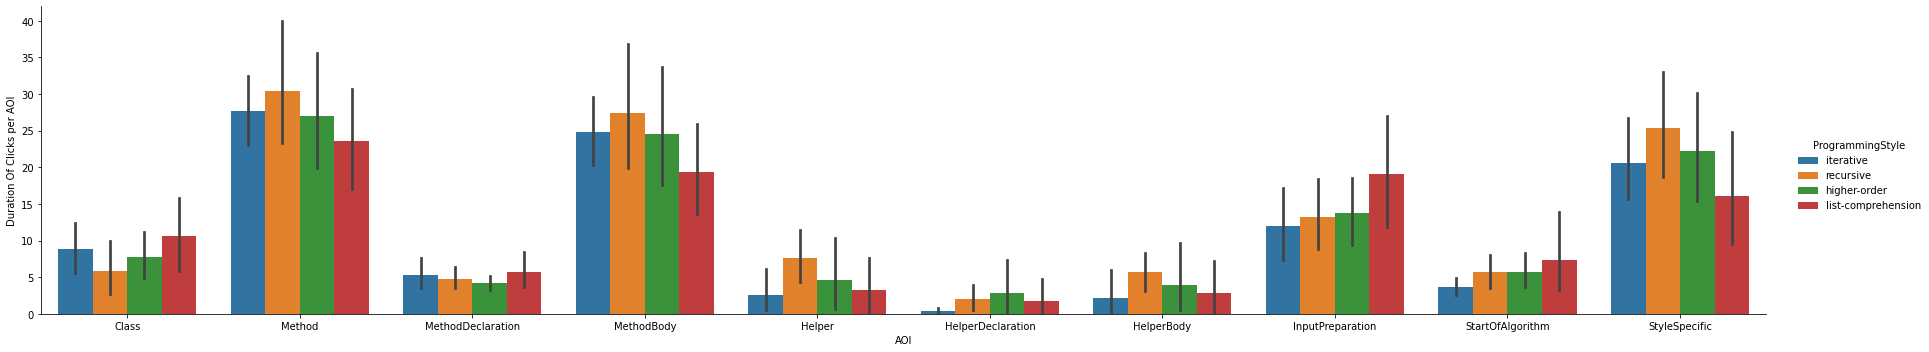

In [13]:
df_total = df_metrics

ax = sns.catplot(x="AOI", y="Duration", hue="ProgrammingStyle", data=df_tmp, kind="bar", height=5,
                 aspect=5, hue_order=["iterative", "recursive", "higher-order", "list-comprehension"],
                 order=aoi_order)
ax.tight_layout()
ax.set(ylabel='Duration Of Clicks per AOI')
plt.savefig("./results/RQ2/figures/RQ2_TimeOfClicks_PerAOI.png")
plt.show()
plt.close('all')

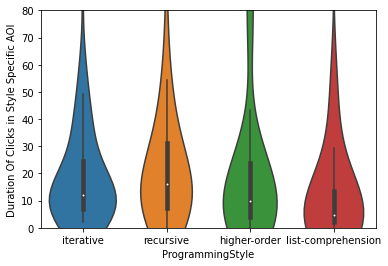

In [14]:
df_total = df_metrics
df_total = df_total[df_total["AOI"] == "StyleSpecific"]
ax = sns.violinplot(x="ProgrammingStyle", y="Duration", data=df_total,
                    order=["iterative", "recursive", "higher-order", "list-comprehension"])
ax.set_ylabel('Duration Of Clicks in Style Specific AOI')
ax.set(ylim=(0.0, 80.0))
plt.savefig("./results/RQ2/figures/RQ2_TimeOfClicks_PerStyleSpecific.png")
plt.show()
plt.close('all')

## Inferential Statistics

In [15]:
df_metrics

,Algorithm,ProgrammingStyle,Participant,AOI,Duration,Amount
0,LinkedList,higher-order,204,Method,25.186,8.0
1,LinkedList,higher-order,204,MethodDeclaration,12.515,3.0
2,LinkedList,higher-order,204,MethodBody,21.321,7.0
3,LinkedList,higher-order,204,Helper,0.000,0.0
4,LinkedList,higher-order,204,HelperDeclaration,0.000,0.0
...,...,...,...,...,...,...
2775,store,recursive,320,HelperBody,29.130,19.0
2776,store,recursive,320,StyleSpecific,39.201,25.0
2777,store,recursive,320,InputPreparation,27.612,20.0
2778,store,recursive,320,StartOfAlgorithm,0.832,1.0


In [16]:
df_result_p = df_metrics.copy()
df_result_p = df_result_p[df_result_p["AOI"] == "StyleSpecific"]
df_result_p = util_stats.mannwhitneyu_for_df(df_result_p, "ProgrammingStyle", "Amount")

df_result_e = df_metrics.copy()
df_result_e = df_result_e[df_result_e["AOI"] == "StyleSpecific"]
df_result_e = util_stats.effectsize_for_df(df_result_e, "ProgrammingStyle", "Amount")

df_result_number = df_result_p.merge(df_result_e, on=["Categorie_A", "Categorie_B"])
df_result_number = df_result_number.round(decimals=3)
df_result_number.to_excel("results/RQ2/data/RQ2_NumberOfClicks_PerStyleSpecific_Stats.xlsx", index=False)
df_result_number

,Categorie_A,Categorie_B,p_value,Significant,Effect_Size,Effect_Size_Interpretation
0,higher-order,iterative,0.000,True,-0.438,medium
1,higher-order,list-comprehension,0.389,False,0.028,negligible
2,higher-order,recursive,0.000,True,-0.479,large
3,iterative,list-comprehension,0.000,True,0.455,medium
4,iterative,recursive,0.040,False,-0.172,small
5,list-comprehension,recursive,0.000,True,-0.481,large


In [17]:
df_result_p = df_metrics.copy()
df_result_p = df_result_p[df_result_p["AOI"] == "StyleSpecific"]
df_result_p = util_stats.mannwhitneyu_for_df(df_result_p, "ProgrammingStyle", "Duration")

df_result_e = df_metrics.copy()
df_result_e = df_result_e[df_result_e["AOI"] == "StyleSpecific"]
df_result_e = util_stats.effectsize_for_df(df_result_e, "ProgrammingStyle", "Duration")

df_result_time = df_result_p.merge(df_result_e, on=["Categorie_A", "Categorie_B"])
df_result_time = df_result_time.round(decimals=3)
df_result_time.to_excel("results/RQ2/data/RQ2_TimeOfClicks_PerStyleSpecific_Stats.xlsx", index=False)
df_result_time

,Categorie_A,Categorie_B,p_value,Significant,Effect_Size,Effect_Size_Interpretation
0,higher-order,iterative,0.069,False,-0.144,negligible
1,higher-order,list-comprehension,0.028,False,0.188,small
2,higher-order,recursive,0.034,False,-0.183,small
3,iterative,list-comprehension,0.000,True,0.405,medium
4,iterative,recursive,0.186,False,-0.088,negligible
5,list-comprehension,recursive,0.000,True,-0.386,medium


## Correlations

### Load Demographics

In [18]:
variable_mapping = {
    "CASE" : "ID",
    "ST04_01" : "C++",
    "ST04_02" : "Java",
    "ST04_03" : "Haskell",
    "ST04_04" : "Python",
    "ST04_05" : "Prolog",
    "ST04_06" : "Rust",
    "ST04_07" : "Kotlin",
    "ST05_01" : "Logical",
    "ST05_02" : "Imperative",
    "ST05_03" : "Functional",
    "ST05_04" : "ObjectOriented",
    "ST12" : "Iteration",
    "ST13" : "Recursion",
    "ST14" : "HigherOrder",
    "ST15" : "ListComprehension",
}

df_demographics = pd.read_csv('./data/preprocessed_total_data.csv')
df_demographics = df_demographics[variable_mapping.keys()]
df_demographics.columns = variable_mapping.values()
df_language = df_demographics.melt(id_vars="ID", value_vars=["C++", "Java", "Haskell", "Python", "Prolog", "Rust", "Kotlin"], value_name="PreExperience", var_name="Language")
df_paradigm = df_demographics.melt(id_vars="ID", value_vars=["Logical", "Imperative", "Functional", "ObjectOriented"], value_name="PreExperience", var_name="Paradigm")
df_style = df_demographics.melt(id_vars="ID", value_vars=["Iteration", "Recursion", "HigherOrder", "ListComprehension"], value_name="PreExperience", var_name="Style")

In [19]:
df_tmp = df_metrics[df_metrics["AOI"] == "StyleSpecific"]
df_tmp = df_tmp.rename({"Participant" : "ID"}, axis=1)
df_tmp = df_tmp.merge(df_demographics, on="ID")
df_tmp = df_tmp[["ProgrammingStyle", "Amount", "Iteration", "Recursion", "HigherOrder", "ListComprehension"]]
df_tmp["Amount"] = df_tmp["Amount"].astype(float)
df_correlation = util_stats.correlations_for_df(df_tmp, "ProgrammingStyle", df_tmp.columns[2:], "Amount")
df_correlation = df_correlation.round(3)
df_correlation.to_excel("./results/RQ2/data/RQ2_NumberOfCLicks_PerStyleSpecific_Correlation.xlsx", index=False)
df_correlation

,ProgrammingStyle,PreExperience,Correlation
0,higher-order,Iteration,-0.155
1,iterative,Iteration,0.070
2,list-comprehension,Iteration,0.030
3,recursive,Iteration,0.163
4,higher-order,Recursion,-0.138
5,iterative,Recursion,0.004
6,list-comprehension,Recursion,0.009
7,recursive,Recursion,-0.060
8,higher-order,HigherOrder,-0.116
9,iterative,HigherOrder,0.092


In [20]:
df_tmp = df_metrics[df_metrics["AOI"] == "StyleSpecific"]
df_tmp = df_tmp.rename({"Participant" : "ID"}, axis=1)
df_tmp = df_tmp.merge(df_demographics, on="ID")
df_tmp = df_tmp[["ProgrammingStyle", "Duration", "Iteration", "Recursion", "HigherOrder", "ListComprehension"]]
df_correlation = util_stats.correlations_for_df(df_tmp, "ProgrammingStyle", df_tmp.columns[2:], "Duration")
df_correlation = df_correlation.round(3)
df_correlation.to_excel("./results/RQ2/data/RQ2_TimeOfCLicks_PerStyleSpecific_Correlation.xlsx", index=False)
df_correlation

,ProgrammingStyle,PreExperience,Correlation
0,higher-order,Iteration,-0.328
1,iterative,Iteration,-0.134
2,list-comprehension,Iteration,-0.133
3,recursive,Iteration,0.109
4,higher-order,Recursion,-0.132
5,iterative,Recursion,-0.238
6,list-comprehension,Recursion,-0.030
7,recursive,Recursion,-0.146
8,higher-order,HigherOrder,-0.085
9,iterative,HigherOrder,-0.072
